# CSE5CV Assignment 2

Use this notebook to complete the coding portion of the assignment. Once you have finished, you can submit your code by downloading the notebook as a .ipynb file (File > Download > Download .ipynb) and submitting that file on LMS.

In [ ]:
# Type your student ID number as an integer here.
# e.g. STUDENT_ID = 22222222
STUDENT_ID = 21744561

**Before you continue**

Running a CNN on video data can be quite slow, so it is a good idea to make use of Google Colab's GPU acceleration to speed things up. To enable this, click Runtime > Change runtime type and select "GPU" as the Hardware accelerator.

Run the cell below to import modules that you are likely to need when completing the assignment.

In [ ]:
import copy
import math

import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import torch
import torchvision
import torchvision.transforms.functional as tvtf

from google.colab import drive

The first thing that we need to do is connect Google Colab to your Google Drive. This allows you to:

* Upload a video file to your Google Drive and read it from this notebook.
* Save detections from this notebook to your Google Drive for later access so you don't need to run a detection model on your video multiple times.
* Write output files to your Google Drive from this notebook so that you can download them for submission.

Here is a step-by-step guide for you to follow:

1. In a new tab, go to https://drive.google.com/ and create a top-level folder for this assignment named `CSE5CV_Assignment`.
2. Double-click on `CSE5CV_Assignment` to open that folder.
3. Upload your video file (e.g. `task1.mkv`) into that folder. You can do this by dragging and dropping or using the "New" button.
4. Run the code cell below to connect your Google Drive with this notebook. You will need to grant permissions for this to work (follow the prompts).

In [ ]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CSE5CV_Assignment

Mounted at /content/drive
/content/drive/MyDrive/CSE5CV_Assignment


Run the cell below to preview the first frame from your video. If your video is called something other than `task1.mkv` (e.g. `task1.mp4`), you will need to edit the first line.

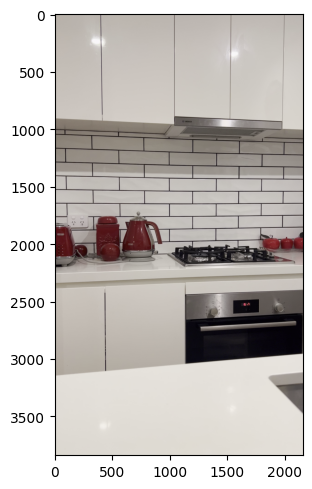

In [ ]:
filename = './task1.MOV'

vid = cv2.VideoCapture(filename)
_, img = vid.read()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
ax.imshow(img)
fig.tight_layout()

Now that you have confirmed that your video is accessible and being read correctly, we can use Mask R-CNN to detect bounding boxes, object class labels, and confidence scores for each frame of the video.

The cell below will take a while to run, but the results will be saved to your Google Drive. This means that you should only ever have to run the cell below once, even if you close the notebook and come back to continue work at a later date. However, if you decide to re-record your video you will need to run the cell again to generate new detections.

In [ ]:
def preprocess_image(image):
    image = tvtf.to_tensor(image)
    image = image.unsqueeze(dim=0)
    return image

maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
maskrcnn.eval()
if torch.cuda.is_available():
    maskrcnn.cuda()

# Go to the start of the video
vid.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Record how long the video is (in frames)
vid_length = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))

# For each frame, read it, give it to maskrcnn and record the detections
all_boxes = []
all_labels = []
all_scores = []
for i in range(vid_length):
    _, img = vid.read()
    if img is None:
        break
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with torch.no_grad():
        input_image = preprocess_image(img)
        if torch.cuda.is_available():
            input_image = input_image.cuda()
        result = maskrcnn(input_image)[0]

    all_boxes.append(result['boxes'].detach().cpu().numpy())
    all_labels.append(result['labels'].detach().cpu().numpy())
    all_scores.append(result['scores'].detach().cpu().numpy())
    if i % 20 == 0:
        print(f'{i+1:0d}/{vid_length}')

torch.save(all_boxes, 'all_boxes.pt')
torch.save(all_labels, 'all_labels.pt')
torch.save(all_scores, 'all_scores.pt')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 187MB/s]


1/1056
21/1056
41/1056
61/1056
81/1056
101/1056
121/1056
141/1056
161/1056
181/1056
201/1056
221/1056
241/1056
261/1056
281/1056
301/1056
321/1056
341/1056
361/1056
381/1056
401/1056
421/1056
441/1056
461/1056
481/1056
501/1056
521/1056
541/1056
561/1056
581/1056
601/1056
621/1056
641/1056
661/1056
681/1056
701/1056
721/1056
741/1056
761/1056
781/1056
801/1056
821/1056
841/1056
861/1056
881/1056
901/1056
921/1056
941/1056
961/1056
981/1056
1001/1056
1021/1056
1041/1056


Now if you go to the `CSE5CV_Assignment` folder on Google Drive you should see three new files where the detections have been stored: `all_boxes.pt`, `all_labels.pt`, and `all_scores.pt`.

Let's load these detections from Google Drive now:

In [ ]:
all_boxes = torch.load('all_boxes.pt')
all_labels = torch.load('all_labels.pt')
all_scores = torch.load('all_scores.pt')

vid_length = len(all_boxes)

print(f'Loaded detections for {vid_length} video frames')

<ipython-input-5-6aa52058e509>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_boxes = torch.load('all_boxes.pt')
<ipython-input-5-6aa52058e509>:2: FutureWarning: You a

Loaded detections for 1054 video frames


Now it's your turn to complete the remaining tasks of the assignment by adding code in code cells below. You will find the "Pedestrian Tracking" lab coding notebook to be a useful reference for completing the assignment.

_You can create additional code cells by clicking the "+ Code" button in the toolbar._

***Task 2.1: Filtering Detections Based on Class-Specific Confidence Thresholds***

In [ ]:
import numpy as np
import torch

all_boxes = torch.load('all_boxes.pt')
all_labels = torch.load('all_labels.pt')
all_scores = torch.load('all_scores.pt')

# (MS COCO indices) and confidence thresholds
class_thresholds = {
    1: 0.6,   # person
    45: 0.5,  # plate
    46: 0.4,  # wine glass
    48: 0.4,  # fork
    50: 0.4,  # spoon
    53: 0.4,  # apple
    78: 0.5,  # microwave
    80: 0.5,  # toaster
    85: 0.5   # clock
}

filtered_boxes = []
filtered_labels = []
filtered_scores = []


vid_length = len(all_boxes)

for frame_idx in range(vid_length):

    boxes = all_boxes[frame_idx]
    labels = all_labels[frame_idx]
    scores = all_scores[frame_idx]

    mask = np.array([
        (label in class_thresholds) and (score >= class_thresholds[label])
        for label, score in zip(labels, scores)
    ])

    filtered_boxes.append(boxes[mask])
    filtered_labels.append(labels[mask])
    filtered_scores.append(scores[mask])

print(f"Filtered detections with class-specific thresholds for {vid_length} frames.")

torch.save(filtered_boxes, 'filtered_boxes.pt')
torch.save(filtered_labels, 'filtered_labels.pt')
torch.save(filtered_scores, 'filtered_scores.pt')

print("Filtered detections saved to disk.")

<ipython-input-6-3e9419046981>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_boxes = torch.load('all_boxes.pt')
<ipython-input-6-3e9419046981>:6: FutureWarning: You a

Filtered detections with class-specific thresholds for 1054 frames.
Filtered detections saved to disk.


***Task 2.2: Visualising Filtered Detections with Bounding Boxes and Labels***

Visualization completed and saved to 'detections_filtered.png'.


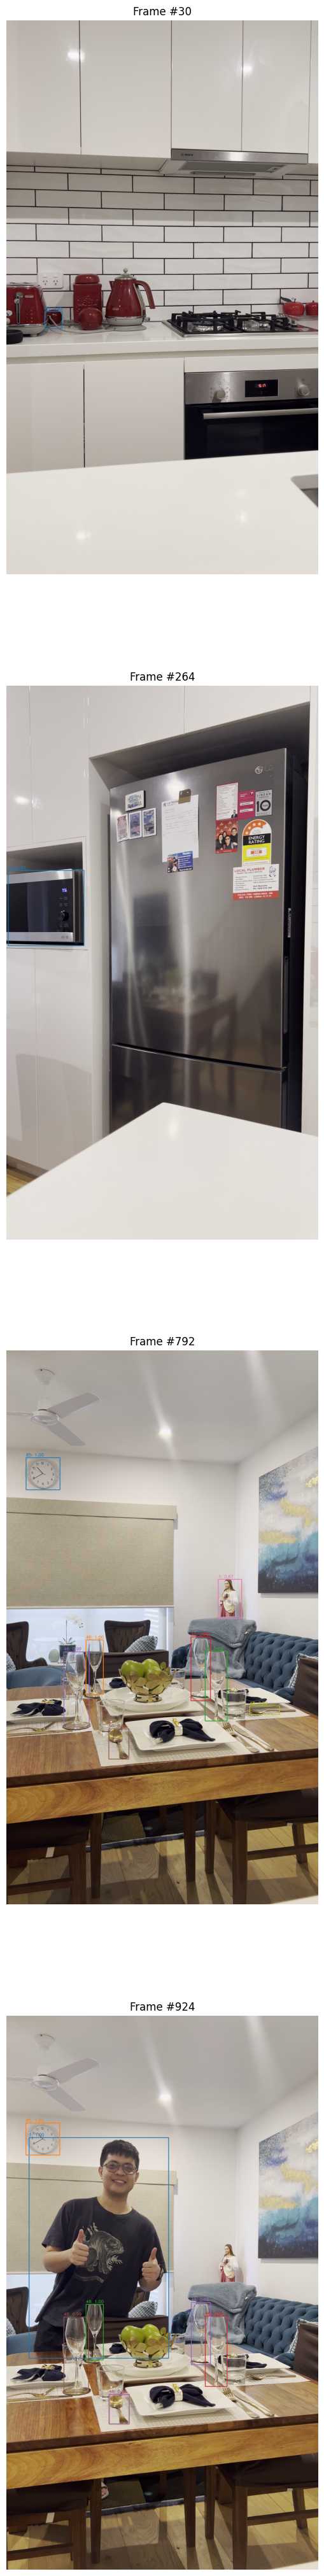

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

COLOURS = [
    tuple(int(colour_hex.strip('#')[i:i+2], 16) for i in (0, 2, 4))
    for colour_hex in plt.rcParams['axes.prop_cycle'].by_key()['color']
]

def draw_detections(img, boxes, labels, scores, colours=COLOURS):
    """Draw bounding boxes, labels, and scores on the image."""
    for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
        i %= len(colours)

        tlx, tly, brx, bry = box
        cv2.rectangle(img, (tlx, tly), (brx, bry), color=colours[i], thickness=4)


        text = f"{label}: {score:.2f}"
        cv2.putText(img, text, (tlx, tly - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, colours[i], 2)


frame_numbers = [30, 264, 792, 924]
n_rows = len(frame_numbers)


vid = cv2.VideoCapture('./task1.MOV')


fig, axes = plt.subplots(n_rows, 1, figsize=(22, 13 * n_rows))


for idx, fr_num in enumerate(frame_numbers):
    vid.set(cv2.CAP_PROP_POS_FRAMES, fr_num)


    success, img = vid.read()
    if not success:
        break
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes = filtered_boxes[fr_num]
    labels = filtered_labels[fr_num]
    scores = filtered_scores[fr_num]

    boxes = boxes.astype(np.int32)

    draw_detections(img, boxes, labels, scores)

    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'Frame #{fr_num}')

plt.savefig('./detections_filtered.png')

print("Visualization completed and saved to 'detections_filtered.png'.")


***Task 3.1: Vectorised Intersection over Union (IoU) Calculation for Bounding Boxes***

In [ ]:
def bbox_iou_matrix(a, b):
    """
    Vectorized IoU calculation for bounding boxes.
    Args:
        a (np.array [N, 4]): N boxes, each as [tlx, tly, brx, bry]
        b (np.array [M, 4]): M boxes, same format as `a`
    Returns:
        np.array [N, M]: IoU for every pair of boxes.
    """
    a = a[:, None]  # [N, 1, 4]
    b = b[None, :]  # [1, M, 4]

    tlx_a, tly_a, brx_a, bry_a = [a[..., i] for i in range(4)]
    tlx_b, tly_b, brx_b, bry_b = [b[..., i] for i in range(4)]

    tlx_overlap = np.maximum(tlx_a, tlx_b)
    tly_overlap = np.maximum(tly_a, tly_b)
    brx_overlap = np.minimum(brx_a, brx_b)
    bry_overlap = np.minimum(bry_a, bry_b)

    intersection = (brx_overlap - tlx_overlap).clip(0) * (bry_overlap - tly_overlap).clip(0)
    area_a = abs((brx_a - tlx_a) * (bry_a - tly_a))
    area_b = abs((brx_b - tlx_b) * (bry_b - tly_b))
    union = area_a + area_b - intersection

    return intersection / union

***Task 3.2: Associating Tracked Objects with New Detections Using IoU***

In [ ]:
def associate(track_boxes, det_boxes):
    """
    Associate track boxes with detection boxes using IoU.
    Args:
        track_boxes (np.array): Last box of active tracks [N, 4]
        det_boxes (np.array): Detections on this frame [M, 4]
    Returns:
        row_ind, col_ind: Index pairs from scipy.optimize.linear_sum_assignment()
    """
    if len(track_boxes) == 0 or len(det_boxes) == 0:
        return [], []

    cost = 1 - bbox_iou_matrix(track_boxes, det_boxes)

    row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost)
    return row_ind, col_ind



***Task 3.3: Tracking Objects Across Frames Using IoU-Based Association***

In [ ]:
def do_tracking(detections, detection_classes):
    """Track objects across frames using IoU-based association."""
    open_tracks = []
    closed_tracks = []

    for i, (det_boxes, det_classes) in enumerate(zip(detections, detection_classes)):
        if len(det_boxes) == 0:
            print(f"Skipping frame {i}: No detections.")
            continue

        track_indices, det_indices = [], []

        if i > 0 and len(open_tracks) > 0:
            track_boxes = np.array([t["boxes"][-1] for t in open_tracks])

            track_indices, det_indices = associate(track_boxes, det_boxes)

        for track_idx, det_idx in zip(track_indices, det_indices):
            open_tracks[track_idx]["boxes"].append(det_boxes[det_idx])
            open_tracks[track_idx]["class"].append(det_classes[det_idx])

        lost_indices = set(range(len(open_tracks))) - set(track_indices)
        for lost_idx in sorted(lost_indices, reverse=True):
            closed_tracks.append(open_tracks.pop(lost_idx))

        new_indices = set(range(len(det_boxes))) - set(det_indices)
        for new_idx in new_indices:
            open_tracks.append({
                "start_frame": i,
                "boxes": [det_boxes[new_idx]],
                "class": [det_classes[new_idx]]
            })

    return closed_tracks + open_tracks


***Task 3.4: Loading Filtered Detections and Performing Object Tracking Across Frames***

In [ ]:
filtered_boxes = torch.load('filtered_boxes.pt')
filtered_labels = torch.load('filtered_labels.pt')

all_tracks = do_tracking(filtered_boxes, filtered_labels)

print(f"Total tracks: {len(all_tracks)}")

Skipping frame 0: No detections.
Skipping frame 1: No detections.
Skipping frame 2: No detections.
Skipping frame 3: No detections.
Skipping frame 4: No detections.
Skipping frame 5: No detections.
Skipping frame 6: No detections.
Skipping frame 7: No detections.
Skipping frame 8: No detections.
Skipping frame 9: No detections.
Skipping frame 10: No detections.
Skipping frame 11: No detections.
Skipping frame 12: No detections.
Skipping frame 13: No detections.
Skipping frame 14: No detections.
Skipping frame 15: No detections.
Skipping frame 16: No detections.
Skipping frame 17: No detections.
Skipping frame 18: No detections.
Skipping frame 21: No detections.
Skipping frame 22: No detections.
Skipping frame 23: No detections.
Skipping frame 24: No detections.
Skipping frame 25: No detections.
Skipping frame 27: No detections.
Skipping frame 28: No detections.
Skipping frame 31: No detections.
Skipping frame 32: No detections.
Skipping frame 33: No detections.
Skipping frame 34: No de

<ipython-input-11-7faf8e01b71e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  filtered_boxes = torch.load('filtered_boxes.pt')
<ipython-input-11-7faf8e01b71e>:3: FutureWa

***Task 3.5: Visualising and Saving Object Tracking Results to Video***

In [ ]:
def visualize_tracking(vid_path, tracks, output_path):
    """Visualize tracking results and save to a video."""
    vid = cv2.VideoCapture(vid_path)
    vid_length = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    vid_out = cv2.VideoWriter(output_path, fourcc, 30, (width, height))

    print(f"Video Length: {vid_length} frames, Width: {width}, Height: {height}")

    for i in range(vid_length):
        success, img = vid.read()
        if not success:
            print(f"Frame {i} could not be read.")
            break

        for t, track in enumerate(tracks):
            start_frame = track["start_frame"]
            inner_idx = i - start_frame

            if 0 <= inner_idx < len(track["boxes"]):
                tlx, tly, brx, bry = track["boxes"][inner_idx].astype(int)
                class_num = track["class"][inner_idx]
                color = COLOURS[t % len(COLOURS)]
                cv2.rectangle(img, (tlx, tly), (brx, bry), color, 2)
                cv2.putText(img, f"Class: {class_num}", (tlx, tly - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, thickness = 4)

        vid_out.write(img)

    vid.release()
    vid_out.release()
    print(f"Video saved as {output_path}")

***Task 3.6: Saving Output to Video File***

In [ ]:
visualize_tracking('./task1.MOV', all_tracks, 'task3.mp4')


Video Length: 1056 frames, Width: 2160, Height: 3840
Frame 1054 could not be read.
Video saved as task3.mp4


***Task 3.7: Downloading the Generated Tracking Video***

In [ ]:
from google.colab import files
files.download('task3.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>